In [1]:
!pip install torchinfo
from torchinfo import summary

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")

100%|██████████| 107M/107M [00:00<00:00, 141MB/s] 

Extracting files...


/root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Image
Image Path: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Image/2012.jpg
Mask Path /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Mask/2012.png


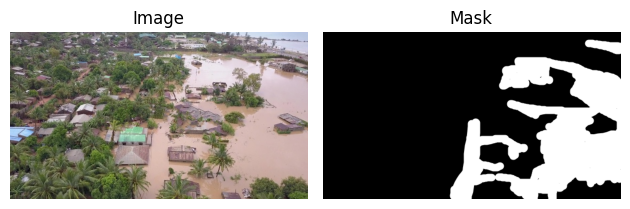

In [35]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import re
import os

def get_image_and_mask(i: int) -> Image:
  image_path = os.path.join(path, os.listdir(path)[1])
  print(image_path)

  first_image = os.listdir(image_path)[i]

  test_img_path = os.path.join(image_path, first_image)
  print("Image Path:", test_img_path)

  mask_path = test_img_path[0:-4] + ".png"
  mask_path = re.sub("Image", "Mask", mask_path)
  print('Mask Path', mask_path)

  img = Image.open(test_img_path)
  mask = Image.open(mask_path)
  fig, axes = plt.subplots(1, 2)
  axes[0].imshow(img)
  axes[0].set_title(Path(test_img_path).parent.stem)
  axes[0].axis(False)

  axes[1].imshow(mask, cmap = "gray")
  axes[1].set_title(Path(mask_path).parent.stem)
  axes[1].axis(False)
  plt.tight_layout()
  plt.show()

get_image_and_mask(88)

In [13]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size = 3, padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(
                out_channels, out_channels, kernel_size = 3, padding = 1
            ),
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv1(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size = 2, stride = 2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1,x2], dim = 1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.downconv1 = DownSample(in_channels, 64)
        self.downconv2 = DownSample(64, 128)
        self.downconv3 = DownSample(128, 256)
        self.downconv4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.upconv1 = UpSample(1024, 512)
        self.upconv2 = UpSample(512, 256)
        self.upconv3 = UpSample(256, 128)
        self.upconv4 = UpSample(128, 64)

        self.out = nn.Conv2d(
            in_channels = 64, out_channels = num_classes, kernel_size = 1
        )
    def forward(self, x):
        down_1, p1 = self.downconv1(x)
        down_2, p2 = self.downconv2(p1)
        down_3, p3 = self.downconv3(p2)
        down_4, p4 = self.downconv4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.upconv1(b, down_4)
        up_2 = self.upconv2(up_1, down_3)
        up_3 = self.upconv3(up_2, down_2)
        up_4 = self.upconv4(up_3, down_1)

        out = self.out(up_4)
        return out
# One class: Either it's a flood or not
unet = UNet(3, 1)

In [14]:
summary(unet)

Layer (type:depth-idx)                   Param #
UNet                                     --
├─DownSample: 1-1                        --
│    └─DoubleConv: 2-1                   --
│    │    └─Sequential: 3-1              38,720
│    └─MaxPool2d: 2-2                    --
├─DownSample: 1-2                        --
│    └─DoubleConv: 2-3                   --
│    │    └─Sequential: 3-2              221,440
│    └─MaxPool2d: 2-4                    --
├─DownSample: 1-3                        --
│    └─DoubleConv: 2-5                   --
│    │    └─Sequential: 3-3              885,248
│    └─MaxPool2d: 2-6                    --
├─DownSample: 1-4                        --
│    └─DoubleConv: 2-7                   --
│    │    └─Sequential: 3-4              3,539,968
│    └─MaxPool2d: 2-8                    --
├─DoubleConv: 1-5                        --
│    └─Sequential: 2-9                   --
│    │    └─Conv2d: 3-5                  4,719,616
│    │    └─ReLU: 3-6                    --

In [64]:
rand_image = torch.randn((1,3,512,512)).to(device)
unet(rand_image).shape

torch.Size([1, 1, 512, 512])

In [67]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms
import os

class FloodDataset(Dataset):
  def __init__(self, img_dir, mask_dir):
    self.original_img_dir = img_dir
    self.original_mask_dir = mask_dir

    self.img_dir = sorted(os.listdir(img_dir))
    self.mask_dir = sorted(os.listdir(mask_dir))
    self.transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])
  def __len__(self):
    return len(self.img_dir)
  def __getitem__(self, i: int):
    img = Image.open(os.path.join(self.original_img_dir, self.img_dir[i])).convert("RGB")
    mask = Image.open(os.path.join(self.original_mask_dir, self.mask_dir[i])).convert("L")
    return self.transform(img), self.transform(mask)

flood_dataset = FloodDataset("/root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Image", "/root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Mask")

train_dataloader = DataLoader(flood_dataset, 4, True)

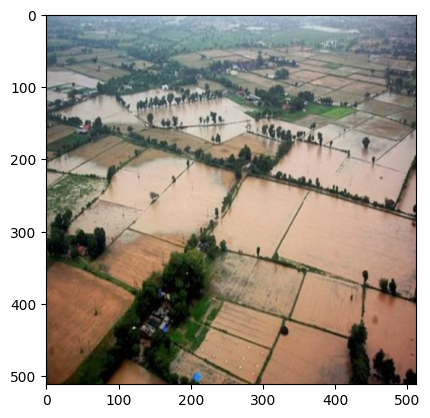

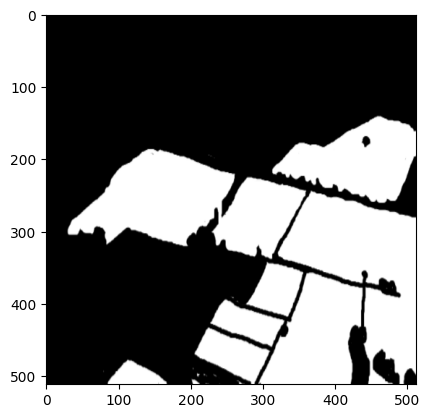

In [70]:
img, mask = next(iter(train_dataloader))
plt.imshow(img[3].permute(1,2,0))
plt.show()
plt.imshow(mask[3].permute(1,2,0), cmap = "grey")
plt.show()

In [71]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [72]:
from pathlib import Path

model_save_path = "model_weights.pth"
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params = unet.parameters(), lr = 1E-3)

EPOCHS = 10

for epoch in range(EPOCHS):
    unet.train().to(device)
    running_loss = 0.0

    for images, masks in train_dataloader:
        images = images.to(device)               # shape (B, C, H, W)
        masks = masks.to(device)                 # shape (B, 1, H, W)

        optimizer.zero_grad()

        outputs = unet(images)                  # raw logits
        loss = loss_fn(outputs, masks.float()) # BCE expects float

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")

torch.save(unet.state_dict(), model_save_path)

Epoch 1/10, Loss: 0.5741
Epoch 2/10, Loss: 0.5157
Epoch 3/10, Loss: 0.5066
Epoch 4/10, Loss: 0.4593
Epoch 5/10, Loss: 0.7291
Epoch 6/10, Loss: 0.6563
Epoch 7/10, Loss: 0.5494
Epoch 8/10, Loss: 0.5111
Epoch 9/10, Loss: 0.4802
Epoch 10/10, Loss: 0.4627


Image Path: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Image/6.jpg
Mask Path: /root/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1/Mask/3082.png


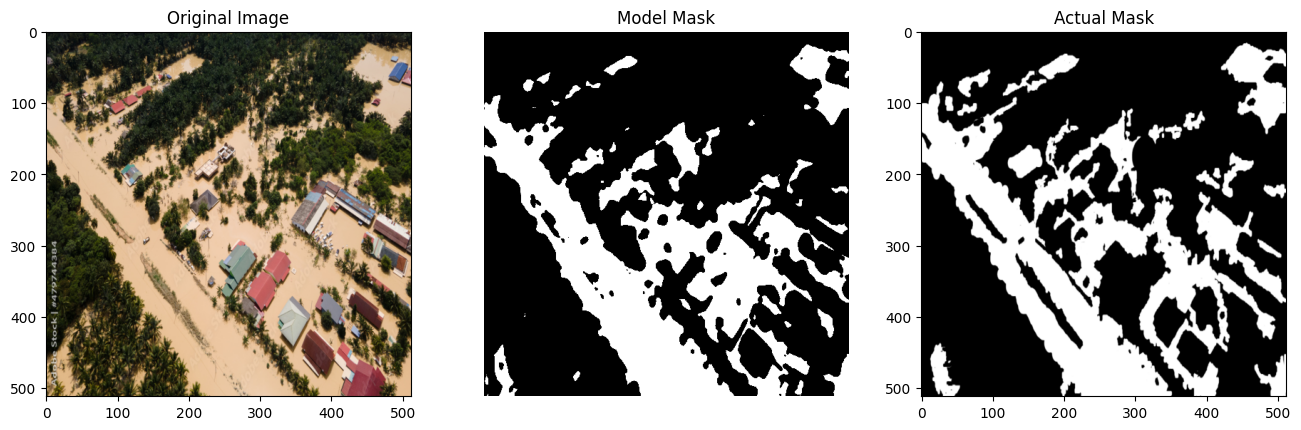

In [89]:
from torchvision import transforms
import re
from PIL import Image

image_transforms = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])
test_unet = UNet(3, 1)

if os.path.exists("model_weights.pth"):
  test_unet.load_state_dict(torch.load("model_weights.pth"))

@torch.inference_mode()
def model_predict_mask(i):
  if i > 290:
    return None
  image_path = os.path.join(path, os.listdir(path)[1])
  mask_path = os.path.join(path, os.listdir(path)[2])

  first_image = os.listdir(image_path)[i]
  first_mask = os.listdir(mask_path)[i]

  test_img_path = os.path.join(image_path, first_image)
  print("Image Path:", test_img_path)
  test_mask_path = os.path.join(mask_path, first_mask)
  print("Mask Path:", test_mask_path)

  mask_path = test_img_path[0:-4] + ".png"
  mask_path = re.sub("Image", "Mask", mask_path)

  # Add batch dim
  img = image_transforms(Image.open(test_img_path).convert("RGB")).unsqueeze(0)
  test_unet.eval()
  pred_mask = test_unet(img).squeeze()

  img = img.squeeze(0).permute(1,2,0)
  # pred_mask = torch.sigmoid(pred_mask.detach())

  # # 1 if > 0.5 else 0
  # print(pred_mask, "\n")
  # # pred_mask = (pred_mask > 0.5).float()
  # print(pred_mask.min(), pred_mask.max(), "\n")
  # print(pred_mask.shape)


  pred_mask[pred_mask < 0]=0
  pred_mask[pred_mask > 0]=1

  fig, axes = plt.subplots(1,3, figsize = (16,16))
  axes[0].imshow(img)
  axes[0].set_title("Original Image")

  axes[1].set_title("Model Mask")
  axes[1].imshow(torch.sigmoid(pred_mask).cpu().numpy(), cmap="gray")
  axes[1].axis(False)

  # Open image to greyscale
  axes[2].imshow(image_transforms(Image.open(mask_path).convert("L")).permute(1,2,0).numpy(), cmap = "grey")
  axes[2].set_title("Actual Mask")

  plt.show()

model_predict_mask(230)